In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps

import os

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [2]:
def testscore(predtmp,oritmp):
    score=1
    pred=np.ravel(predtmp)
    ori=np.ravel(oritmp)
    n=0
    for i in range(len(pred)):
        if ori[i]!=0:
            n=n+1
    print(n)
    for i in range(len(pred)):
        if ori[i]!=0:
            score=score-1/n*abs(pred[i]-ori[i])/abs(ori[i])
            #print(abs(pred[i]-ori[i])/abs(ori[i]))
    print('score:')
    print(score)
    return score

In [3]:

file_path = os.path.join('D:\\', 'hotaidata','sr_C1_20')
x=[]
y=[]
vx=[]
vy=[]
isvalid=[]
xtmp=[]
ytmp=[]
vxtmp=[]
vytmp=[]
isvalidtmp=[]
for root,dirs,files in os.walk(file_path):
    #print(root)
    
    for dir in dirs:
        #print(os.path.join(root,file))

            with open(os.path.join(root,dir,'B00001.dat'), 'r') as f:  
                lines = f.readlines()
                for line in lines[3:]: 
                    num=line.split()
                    xtmp.append(float(num[0]))
                    ytmp.append(float(num[1]))
                    vxtmp.append(float(num[2]))
                    vytmp.append(float(num[3]))
                    isvalidtmp.append(float(num[4]))

            x.append(np.array(xtmp).reshape(25,25))
            y.append(np.array(ytmp).reshape(25,25))
            vx.append(np.array(vxtmp).reshape(25,25))
            vy.append(np.array(vytmp).reshape(25,25))
            isvalid.append(np.array(isvalidtmp).reshape(25,25))
            xtmp=[]
            ytmp=[]
            vxtmp=[]
            vytmp=[]
            isvalidtmp=[]
#
x=np.array(x)
y=np.array(y)
vx=np.array(vx)
vy=np.array(vy)
isvalid=np.array(isvalid)

x=x.T
y=y.T
vx=vx.T
vy=vy.T
#print(x[0,:,:])
t=np.linspace(0,60/800,121)

dt=t[1]-t[0]
t=t[80:120]


In [4]:



spatial_grid = np.asarray([x[:,:,0].T,y[:,:,0].T]).T
'''
print('spatial_grid')
print(spatial_grid.shape)
print(spatial_grid)
'''

n=25

u=np.zeros((n,n,121, 2))

u[:, :, :, 0] = vx
u[:, :, :, 1] = vy
u_train=u[:,:,80:120,:]

'''
u_train[:, :, :, 0] = x
u_train[:, :, :, 1] = y
'''
u_dot_train = ps.FiniteDifference(axis=2)._differentiate(u_train, dt)
#print(u_dot_train[10,10])
tmp=u_train+u_dot_train*dt
testscore(tmp[:,:,:len(t)-1],u_train[:,:,1:])
#testscore(u_dot_train,u_test)

24120
score:
-3.4547590911934947


-3.4547590911934947

In [5]:
# Define PDE library that is quadratic in u, and
# fourth-order in spatial derivatives of u.
library_functions = [
    lambda y: y,
    lambda x: x * x * x,

    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda y: y,
    lambda x: x + x + x,

    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=spatial_grid,
    include_bias=True,
    is_uniform=True,
    periodic=True
)


# Again, loop through all the optimizers
#print('STLSQ model: ')
print('u_train')
print(u_train.shape)



'''
print('SINDy')
model = ps.SINDy(feature_names=['Vx','Vy'])

model.fit(u_train, x_dot=u_dot_train)
model.print()
u_dot_stlsq = model.predict(u_train)
'''
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=50, alpha=1e-5, 
                     normalize_columns=True, max_iter=200)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy'])
model.fit(u_train, x_dot=u_dot_train)
model.print()
'''
print('SR3 model, L0 norm: ')
optimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy'])
model.fit(u_train, t=dt)
model.print()


print('SR3 model, L1 norm: ')
optimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15,
                   thresholder='l1', normalize_columns=True)

model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train, x_dot=u_dot_train)
model.print()'''

u_train
(25, 25, 40, 2)
STLSQ model: 
(Vx)' = 32.833 1 + 20.690 Vx + 2.284 Vy + -0.497 VxVxVx + -0.522 VyVyVy + -4.108 VxVyVy + -0.600 VxVxVy + 213.434 Vx_2 + 176.936 Vy_2 + 244.485 Vx_22 + 7.087 Vy_22 + 170.781 Vx_1 + -75.848 Vy_1 + 122.329 Vx_12 + -560.245 Vy_12 + 38.534 Vx_11 + 66.389 Vy_11 + -113.325 VxVx_2 + -64.639 VxVy_2 + 0.096 VyVx_2 + -0.446 VyVy_2 + 4.652 VxVxVxVx_2 + 1.499 VxVxVxVy_2 + 76.544 VyVyVyVx_2 + 13.610 VyVyVyVy_2 + -1.564 VxVyVyVx_2 + 0.206 VxVyVyVy_2 + 0.962 VxVxVyVx_2 + -3.170 VxVxVyVy_2 + -71.015 VxVx_22 + -468.721 VxVy_22 + 0.198 VyVx_22 + 4.851 VyVy_22 + 9.597 VxVxVxVx_22 + 2.843 VxVxVxVy_22 + 324.291 VyVyVyVx_22 + 161.842 VyVyVyVy_22 + -4.607 VxVyVyVx_22 + -1.872 VxVyVyVy_22 + -4.852 VxVxVyVx_22 + -9.551 VxVxVyVy_22 + 63.104 VxVx_1 + 6.332 VxVy_1 + -0.830 VyVx_1 + -0.232 VyVy_1 + -3.292 VxVxVxVx_1 + 3.675 VxVxVxVy_1 + 89.378 VyVyVyVx_1 + -49.627 VyVyVyVy_1 + -1.967 VxVyVyVx_1 + 0.377 VxVyVyVy_1 + -1.205 VxVxVyVx_1 + -0.285 VxVxVyVy_1 + -165.703 VxVx_12 + -22

"\nprint('SR3 model, L0 norm: ')\noptimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,\n                   thresholder='l0', normalize_columns=True)\nmodel = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy'])\nmodel.fit(u_train, t=dt)\nmodel.print()\n\n\nprint('SR3 model, L1 norm: ')\noptimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15,\n                   thresholder='l1', normalize_columns=True)\n\nmodel = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)\nmodel.fit(u_train, x_dot=u_dot_train)\nmodel.print()"

In [6]:
t_test=np.arange(0,25,1)
# Predict derivatives using the learned model
x_dot_test_predicted = model.predict(u_train)
print(x_dot_test_predicted.shape)
#print(x_dot_test_predicted[0])
#print(x_dot_test_predicted.shape)
dottmp=np.array(x_dot_test_predicted)
pltpredict=u_train+dottmp*dt

(25, 25, 40, 2)


In [7]:
print(pltpredict[:,:,:39,:].shape)

(25, 25, 39, 2)


In [8]:

# Make fancy plot comparing derivative
plt.figure(figsize=(4, 4))
#plt.subplot(1, 3, 1)

print(x.shape)

'''
print(plttestvx[0].shape)
print(plttestvx[0])

print(y.shape)
print(y[0,:,0])
ytmp=y[0,:,0]
ytmp=ytmp[::-1]
plt.figure(figsize=(4, 4))
plt.streamplot(x[0][0],ytmp,vx_dot[:,:,0],vy_dot[:,:,0])

plt.show()
'''
print('x')
print(x[0].shape)
print('vx_dot[:,:,i]')
#print(vx_dot[:,:,i].shape)
print('pltpredict')


utmp_train=u_train+u_dot_train*0
pltpredict=pltpredict[:,:,:,:]

print(pltpredict.shape)
print(utmp_train.shape)
print('score')
print(testscore(pltpredict,utmp_train))
print('is')
print(len(t))

(25, 25, 121)
x
(25, 121)
vx_dot[:,:,i]
pltpredict
(25, 25, 40, 2)
(25, 25, 40, 2)
score
24740
score:
0.7050151927116316
0.7050151927116316
is
40


<Figure size 400x400 with 0 Axes>

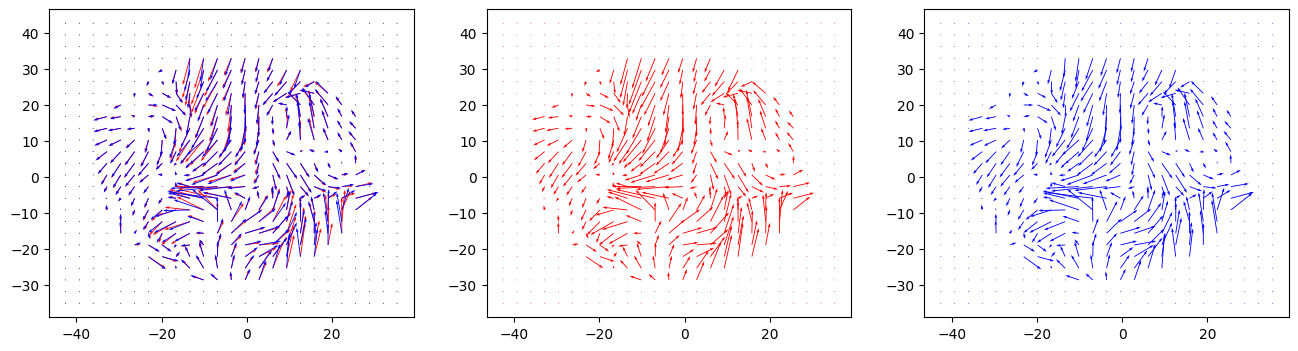

score
620
score:
0.6517563564170749
0.6517563564170749


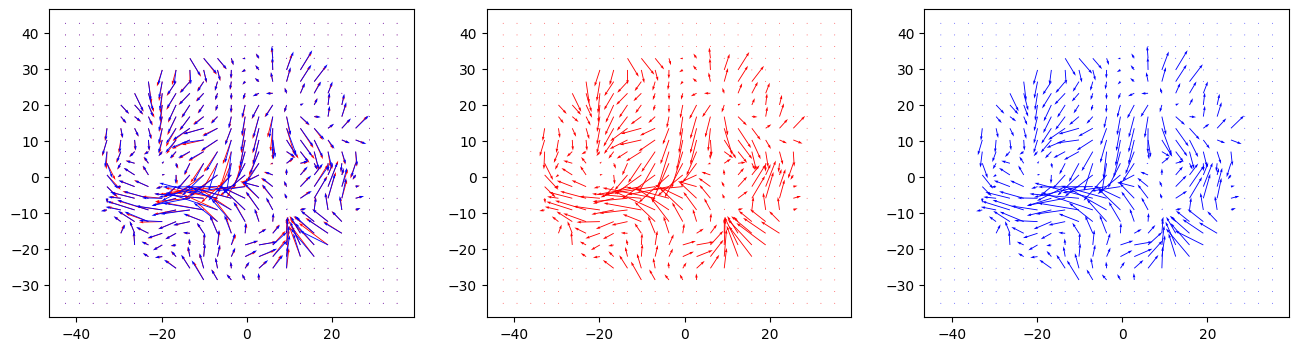

score
616
score:
0.7488140944402378
0.7488140944402378


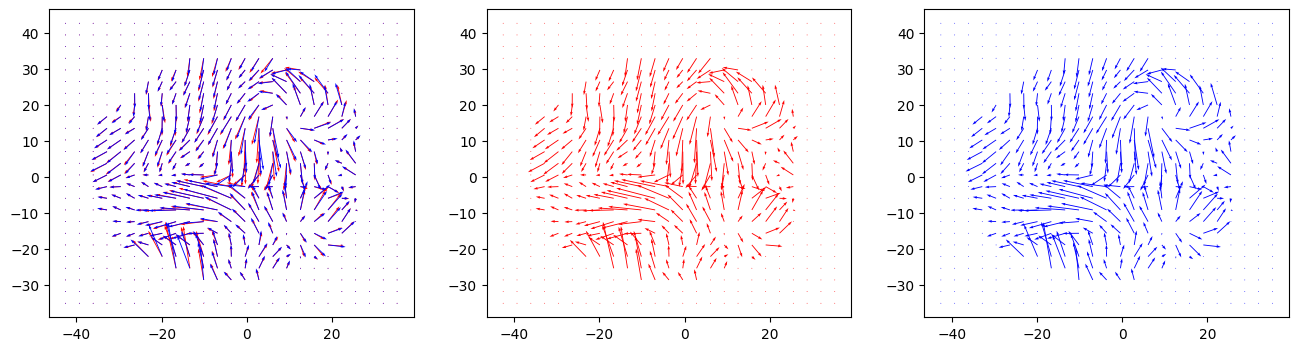

score
620
score:
0.812343006112232
0.812343006112232


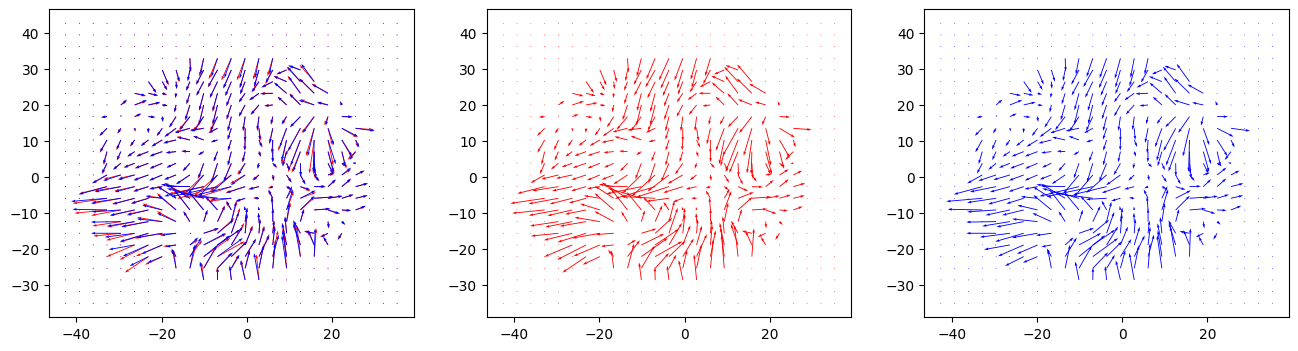

score
618
score:
0.08778123065333836
0.08778123065333836


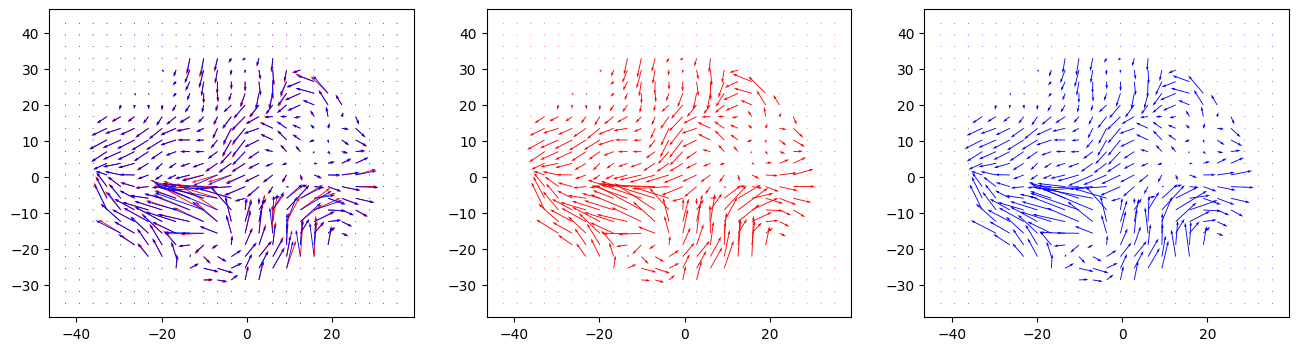

score
620
score:
0.7794224088365104
0.7794224088365104


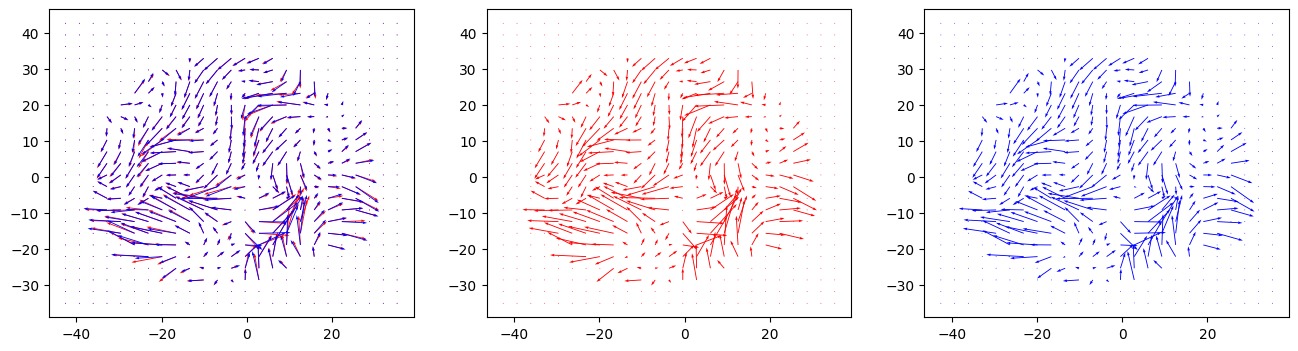

score
618
score:
0.7447336460353349
0.7447336460353349


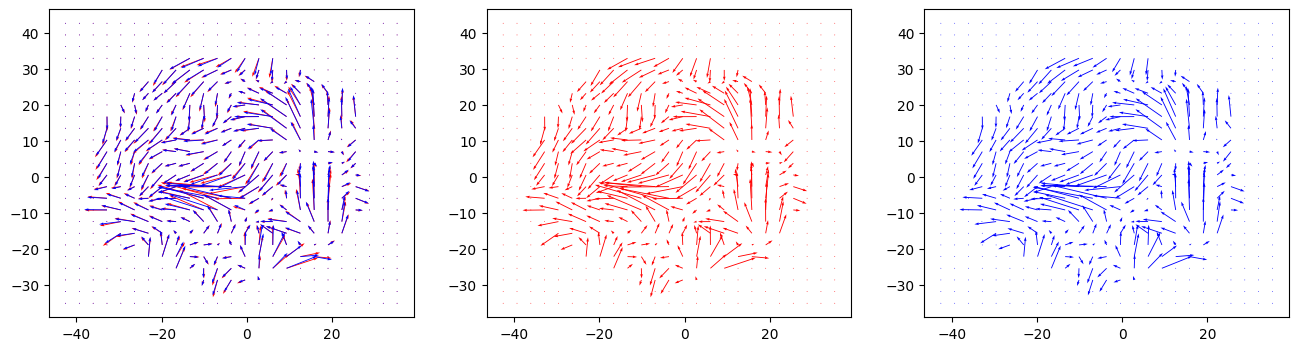

score
620
score:
0.8070733252836224
0.8070733252836224


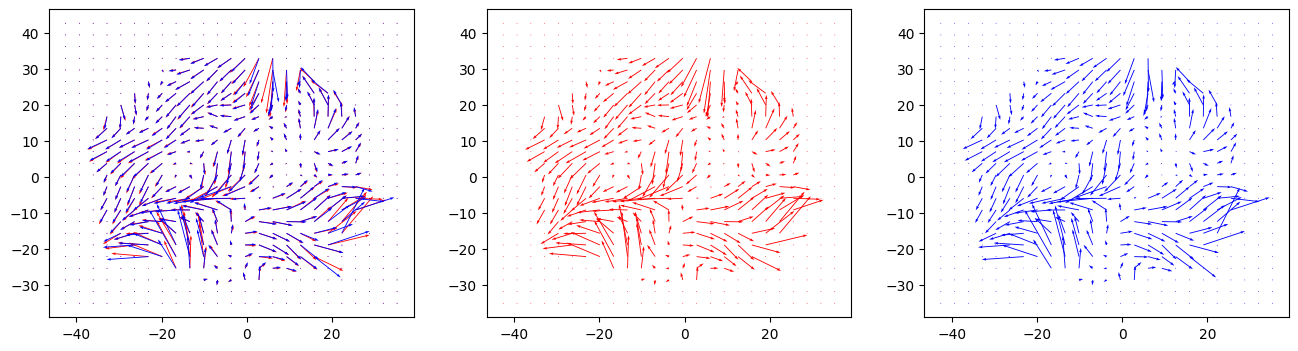

score
620
score:
0.7073748769114522
0.7073748769114522


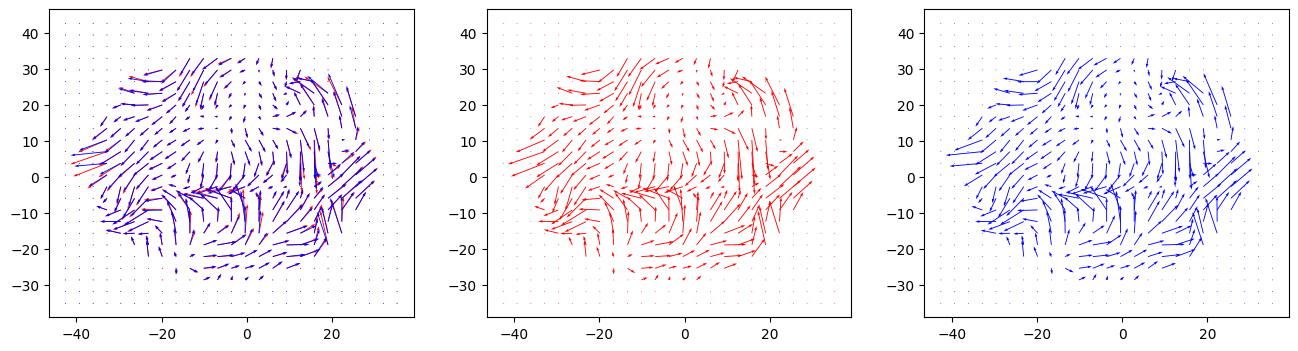

score
620
score:
0.6663986702389657
0.6663986702389657


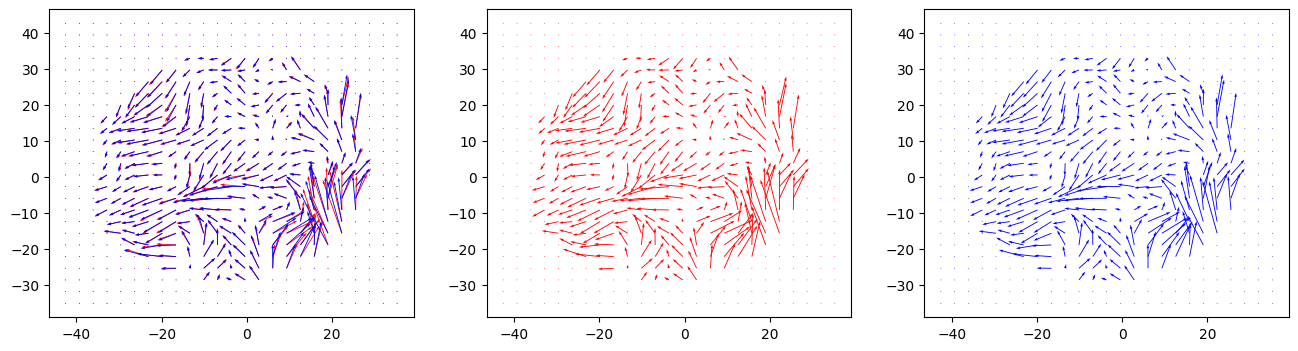

score
618
score:
0.8081847419090965
0.8081847419090965


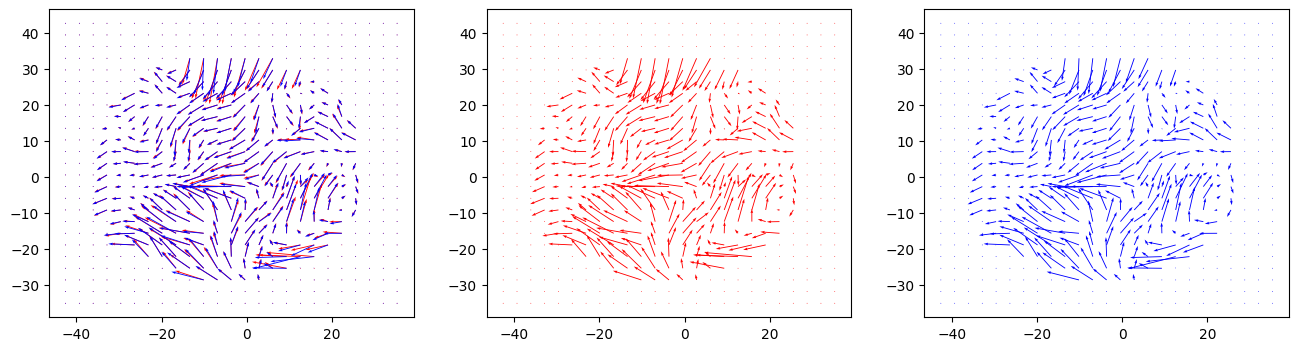

score
616
score:
0.7924768566767191
0.7924768566767191


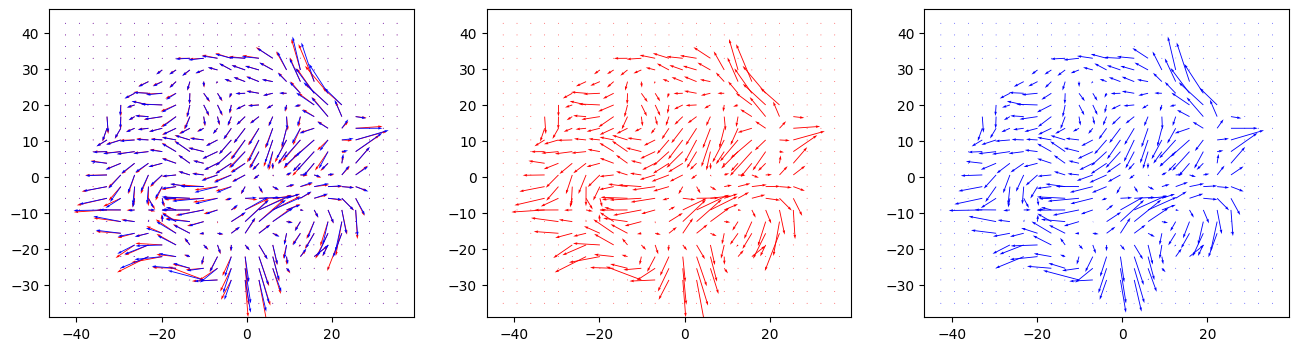

score
620
score:
0.5777167745013264
0.5777167745013264


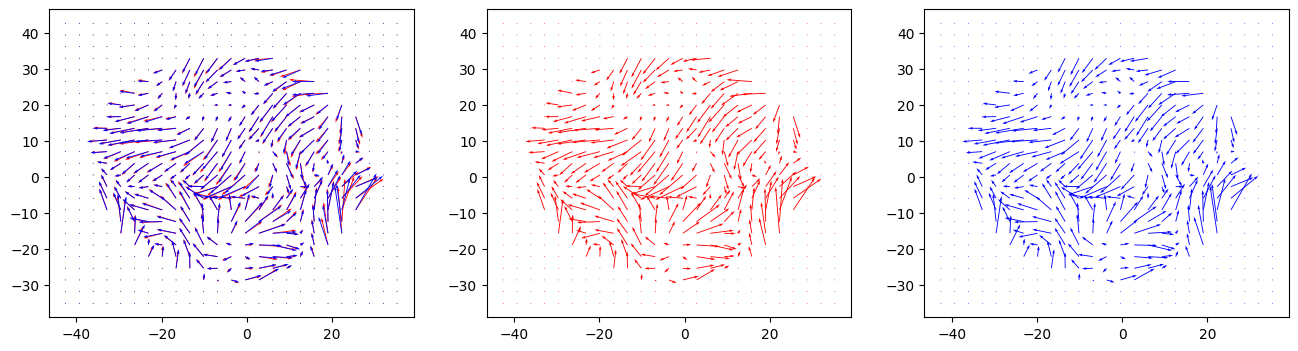

score
618
score:
0.8520390727033005
0.8520390727033005


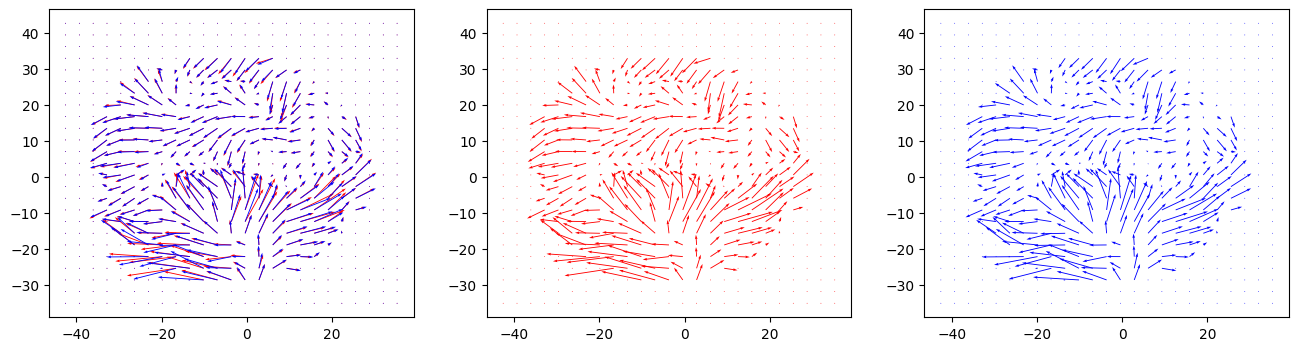

score
620
score:
0.8314333049207469
0.8314333049207469


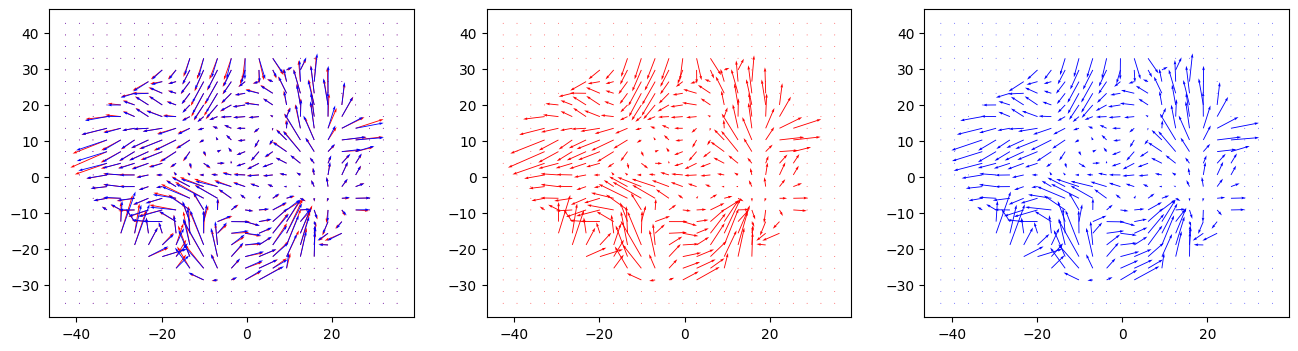

score
618
score:
0.7060759047462795
0.7060759047462795


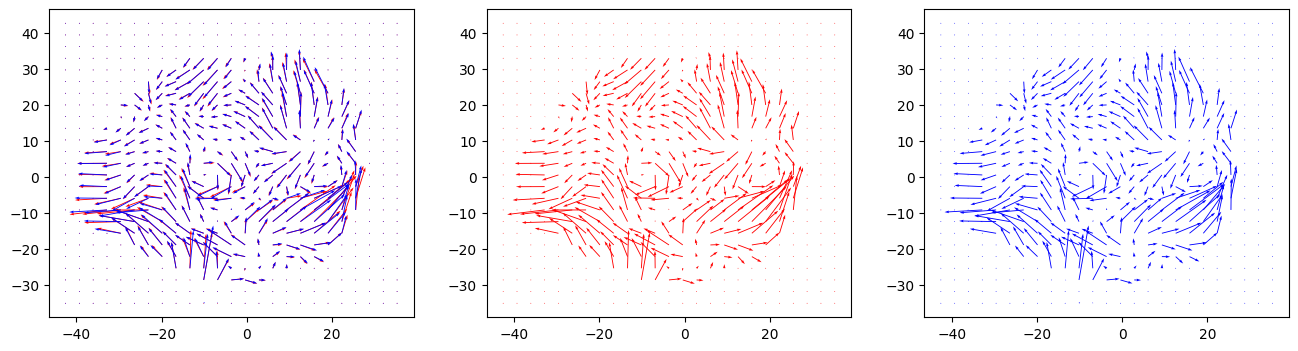

score
618
score:
0.3523300880283169
0.3523300880283169


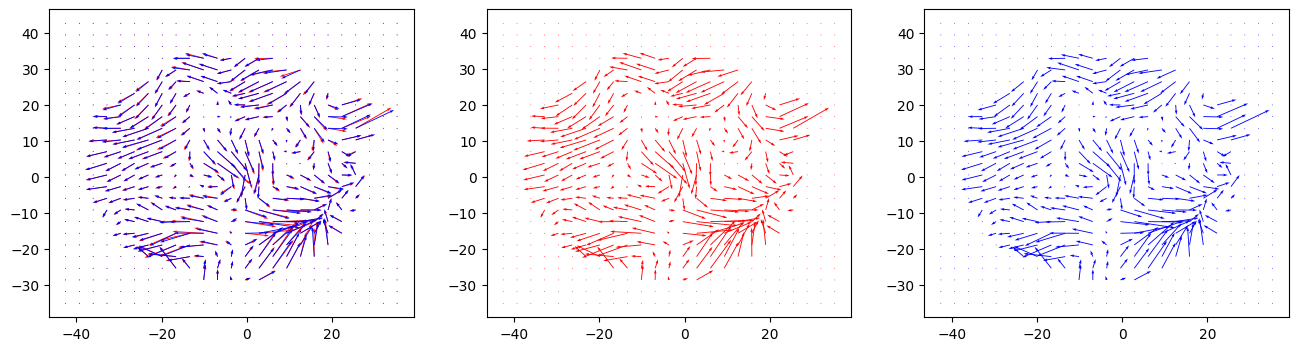

score
618
score:
0.8020458317777013
0.8020458317777013


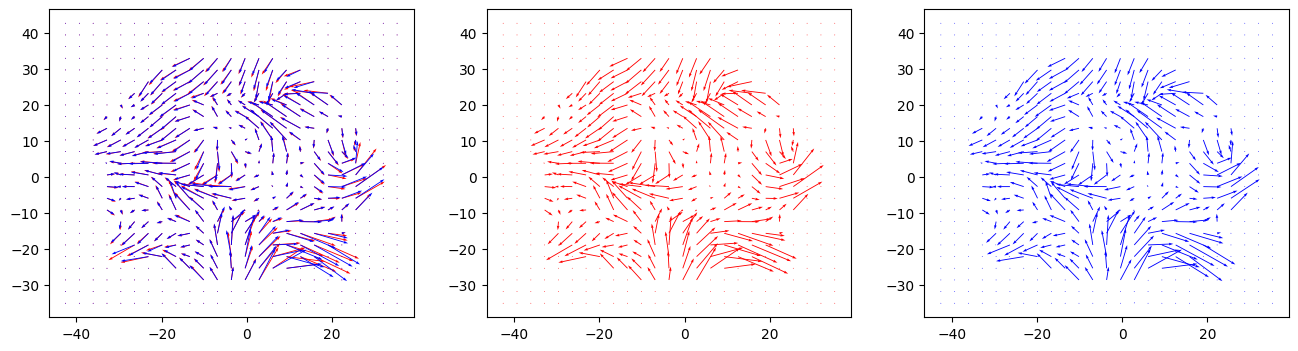

score
620
score:
0.8250702958962698
0.8250702958962698


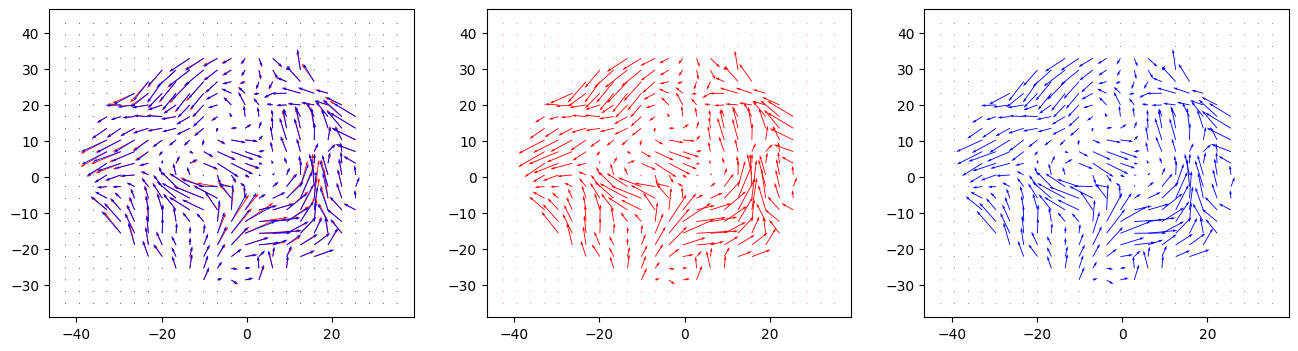

score
620
score:
0.8714018687492711
0.8714018687492711


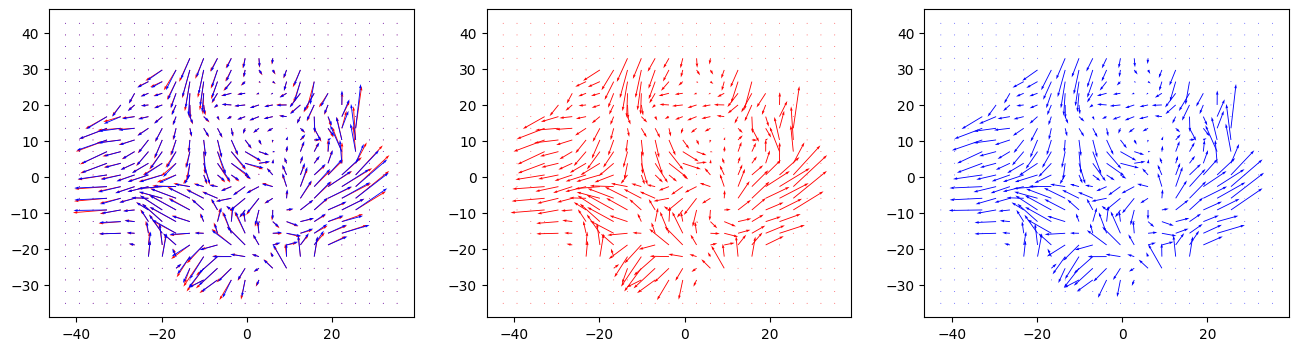

score
618
score:
0.8071665630214768
0.8071665630214768


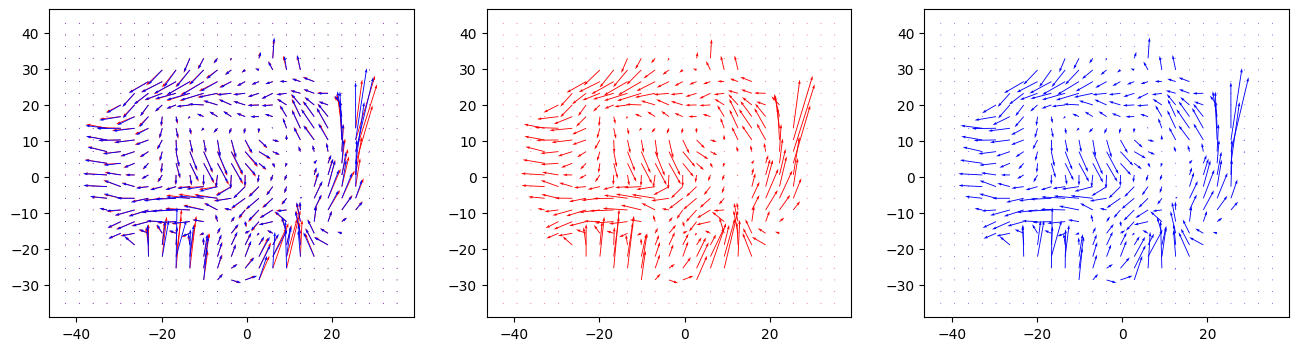

score
616
score:
0.8023841840072888
0.8023841840072888


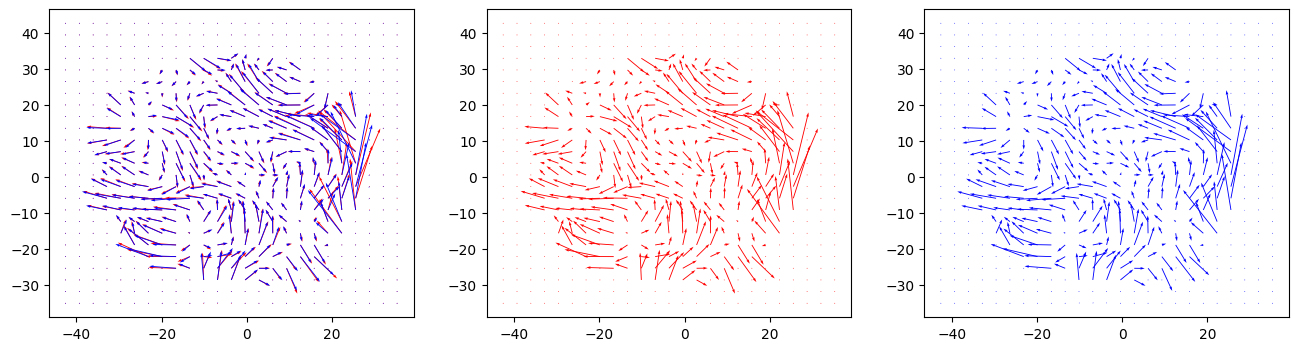

score
618
score:
0.8323594987265829
0.8323594987265829


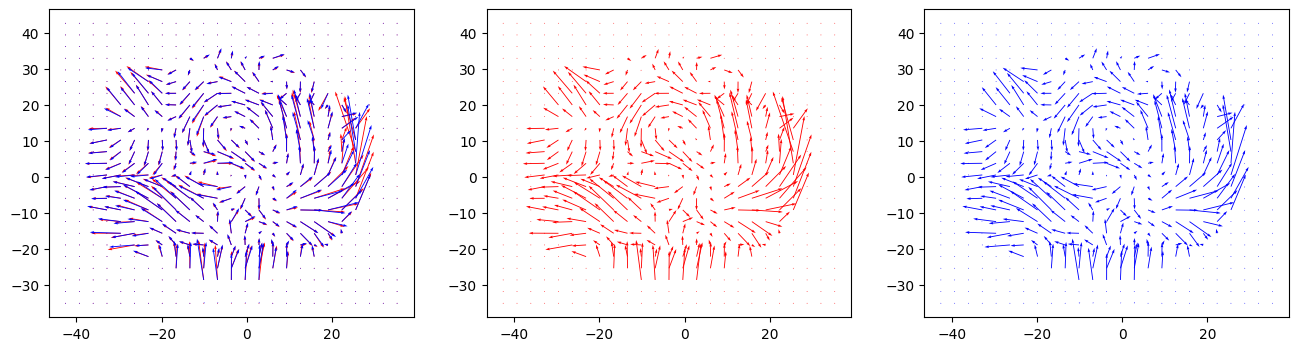

score
616
score:
0.6066040979196923
0.6066040979196923


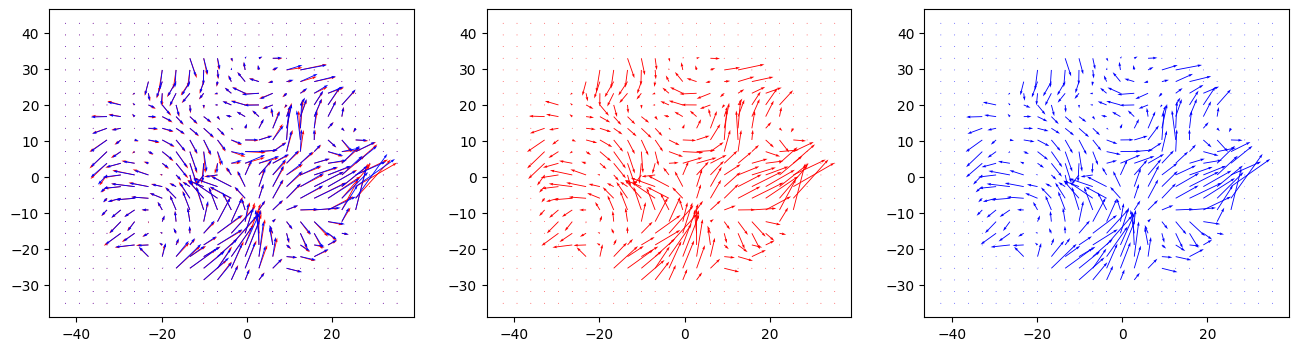

score
618
score:
0.7561766757163983
0.7561766757163983


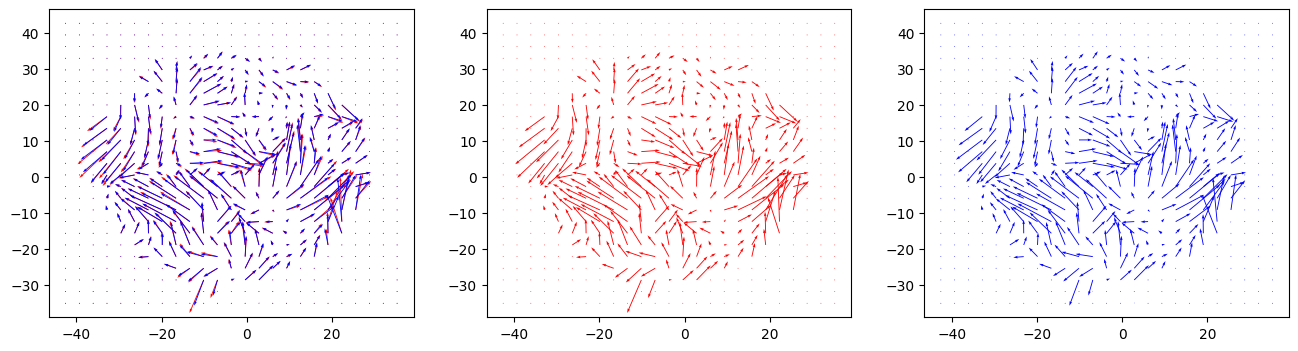

score
618
score:
0.8156923568144611
0.8156923568144611


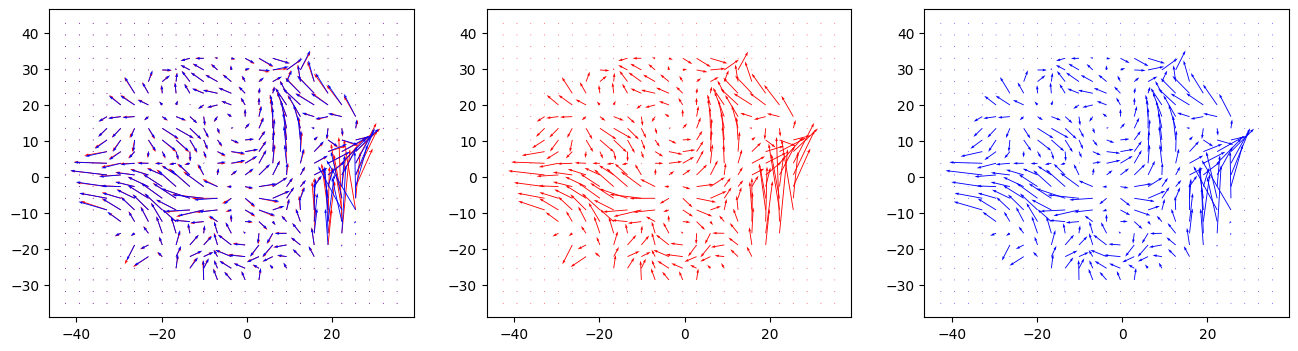

score
620
score:
0.5044983549487488
0.5044983549487488


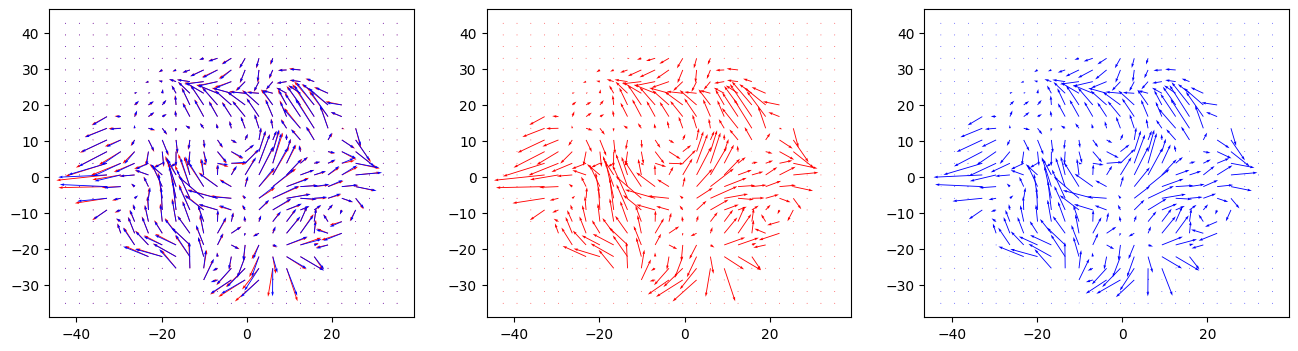

score
618
score:
0.8540155534931734
0.8540155534931734


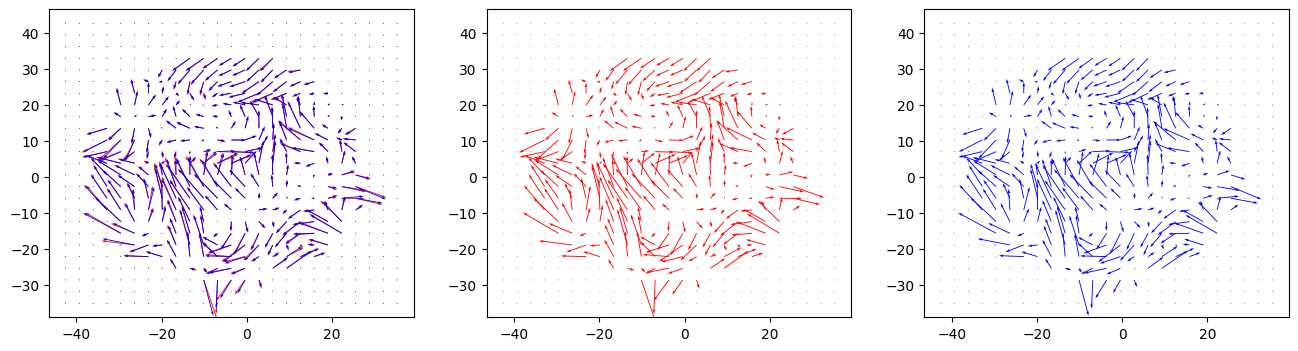

score
616
score:
0.6188095797248095
0.6188095797248095


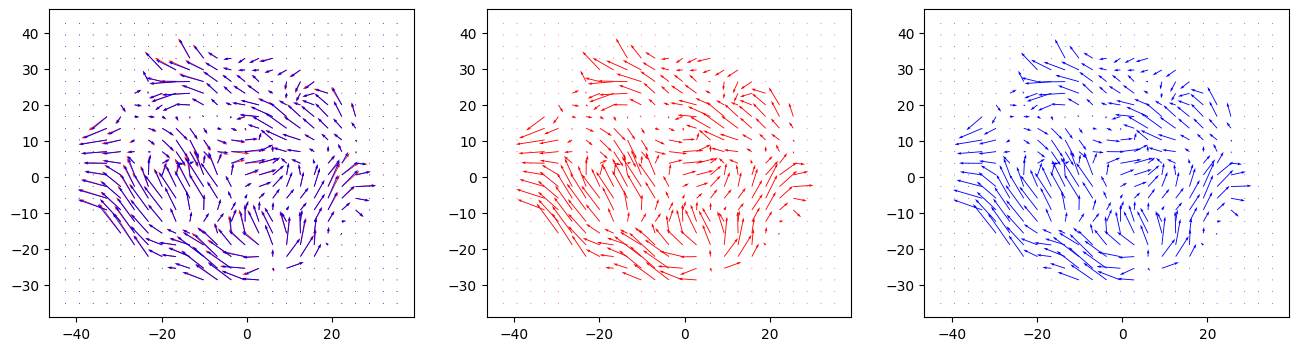

score
620
score:
0.8508333407840011
0.8508333407840011


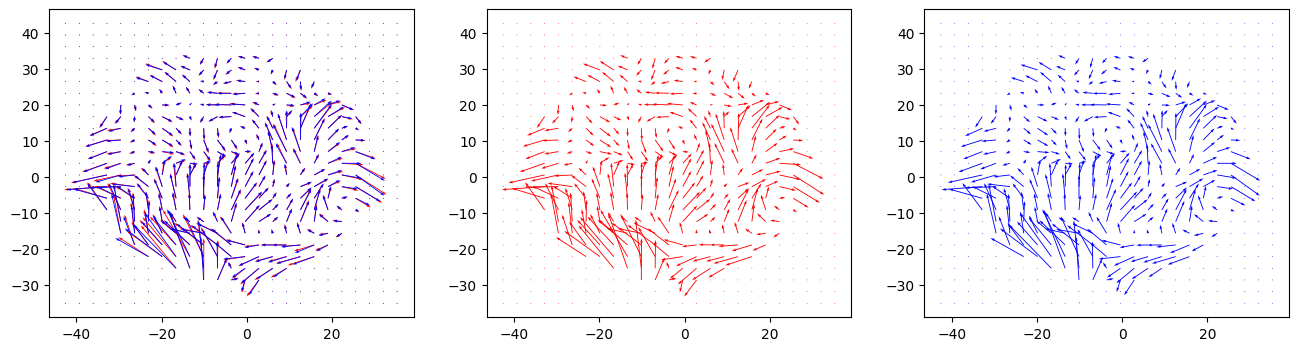

score
620
score:
0.8051504130488096
0.8051504130488096


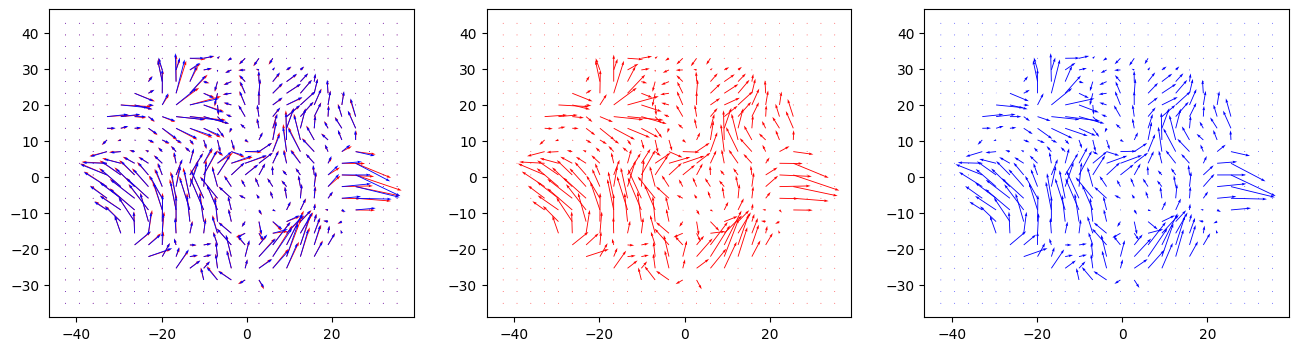

score
620
score:
0.34050768761728467
0.34050768761728467


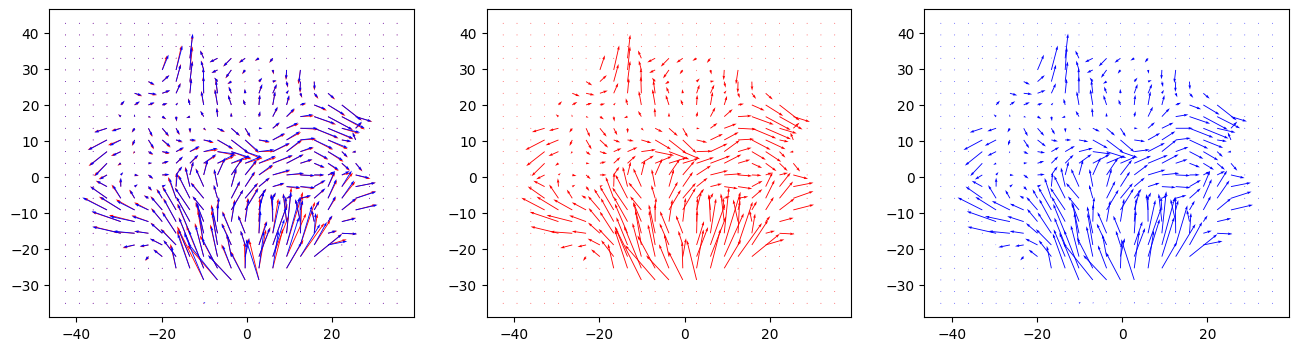

score
618
score:
0.4521290024633178
0.4521290024633178


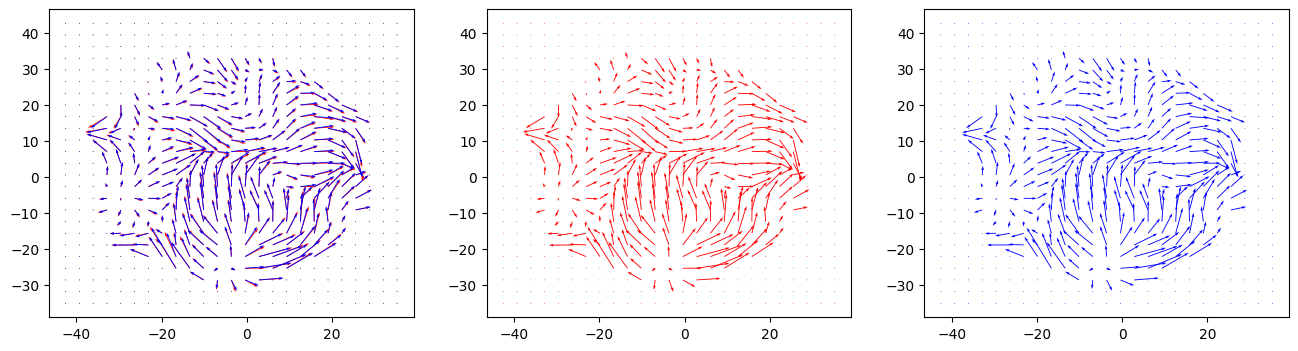

score
620
score:
0.7840876159127905
0.7840876159127905


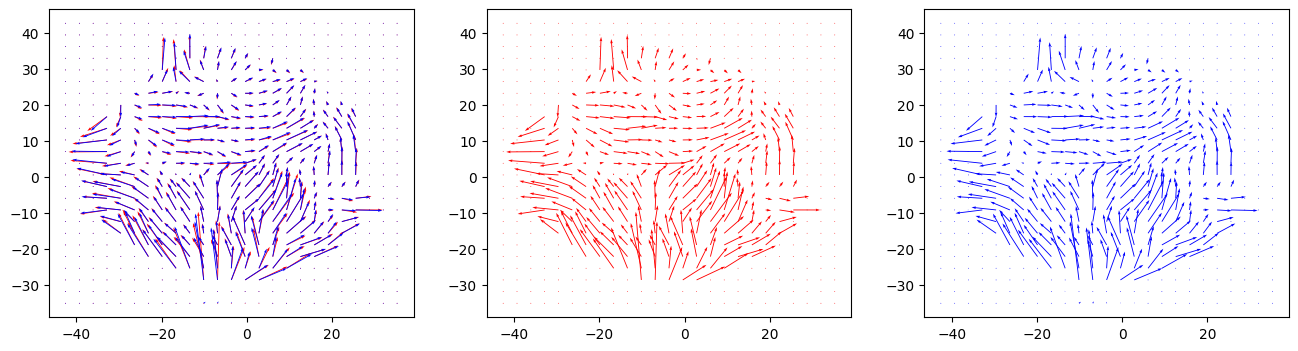

score
620
score:
0.7216256535918826
0.7216256535918826


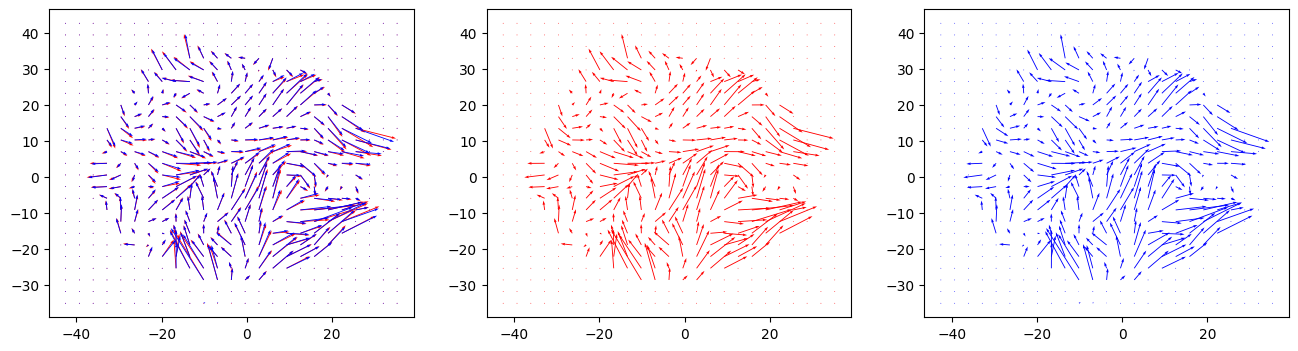

score
616
score:
0.8026296507794817
0.8026296507794817


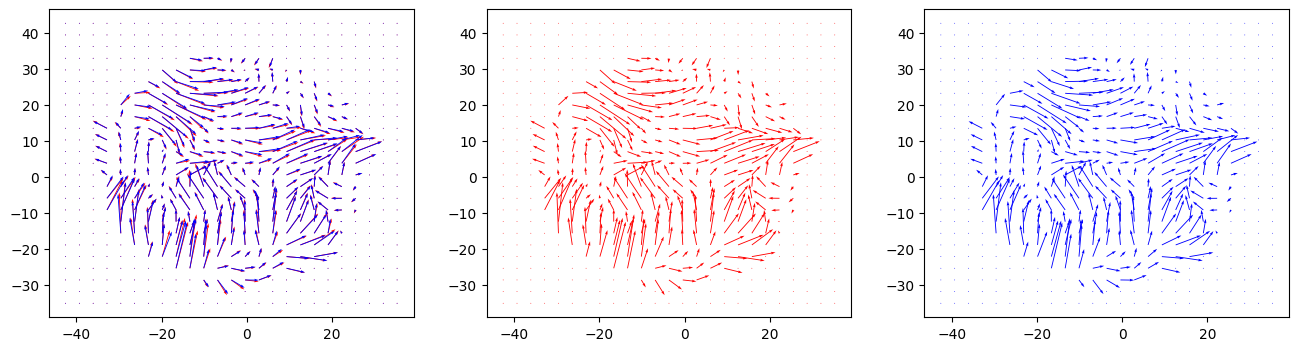

score
616
score:
0.8129339652537643
0.8129339652537643


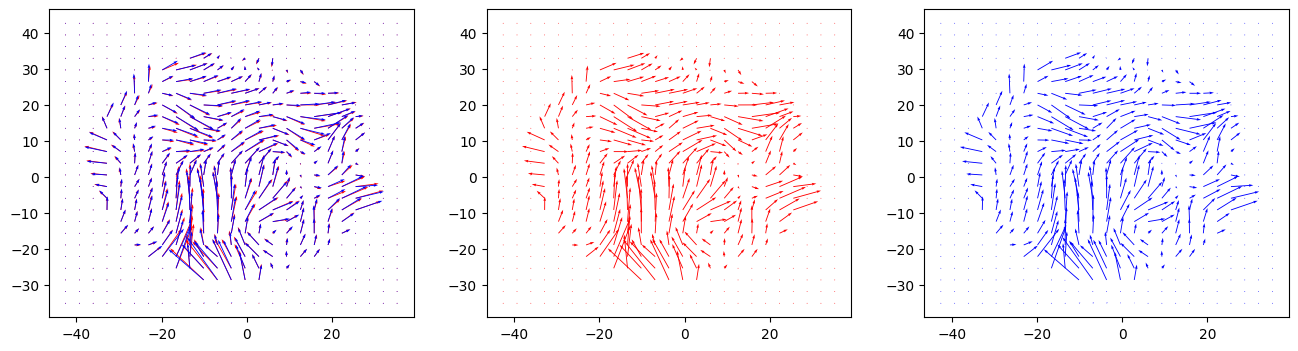

score
620
score:
0.6710702210865659
0.6710702210865659


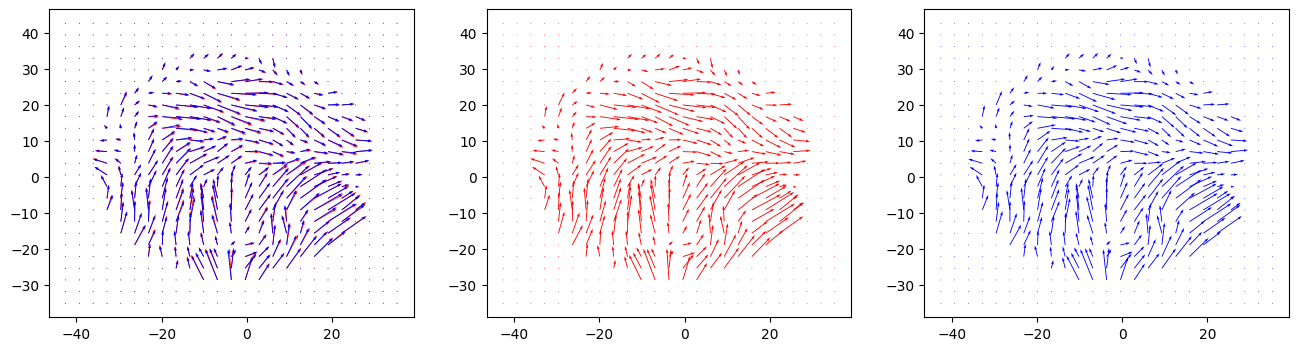

score
620
score:
0.8359167849407699
0.8359167849407699


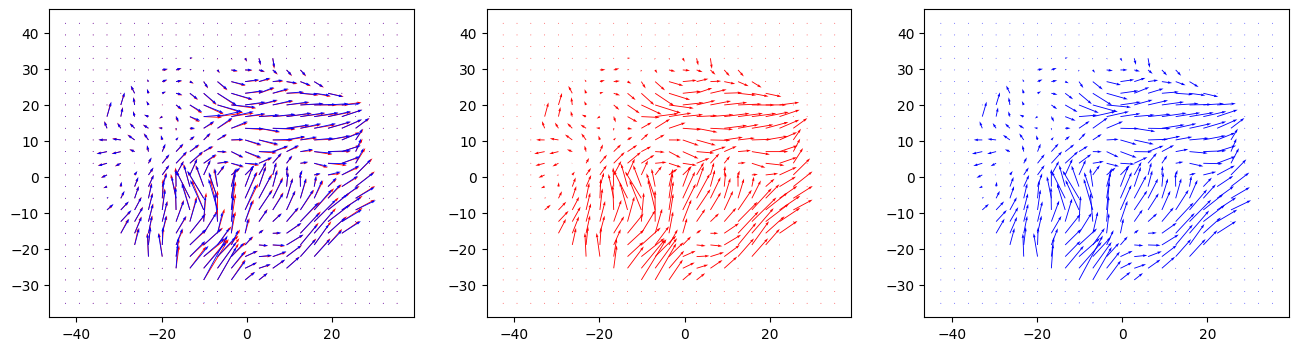

score
618
score:
0.2509194704597737
0.2509194704597737


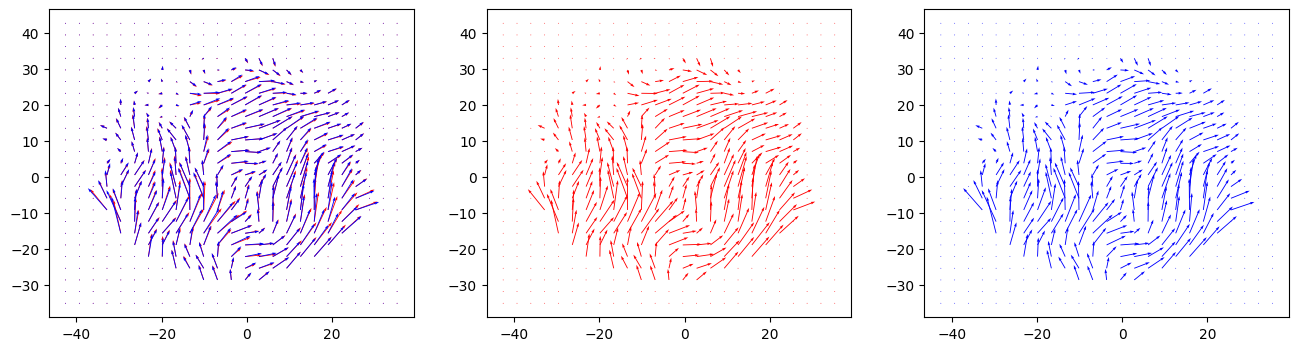

score
616
score:
0.8507602290289581
0.8507602290289581


In [9]:
for i in range(40):
    u_dot_train[:,:,i,0]
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],utmp_train[:,:,i,0],utmp_train[:,:,i,1],color='r')
    plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
    plt.subplot(1, 3, 2)
    plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],utmp_train[:,:,i,0],utmp_train[:,:,i,1],color='r')
    #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
    plt.subplot(1, 3, 3)
    #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],u_dot_train[:,:,i+1,0],u_dot_train[:,:,i+1,1],color='r')
    plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
    plt.show()
    print('score')
    print(testscore(pltpredict[:,:,i,],utmp_train[:,:,i,:]))
